In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [37]:
def retrieve_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start = start_date, end = end_date)
    return data

In [38]:
stock_data = retrieve_stock_data("NVDA", "2020-01-01","2025-02-10")


[*********************100%***********************]  1 of 1 completed


In [39]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.972710,5.972710,5.893293,5.943831,237536000
2020-01-03,5.877112,5.920928,5.828067,5.852963,205384000
2020-01-06,5.901758,5.906986,5.757613,5.783753,262636000
2020-01-07,5.973208,6.019016,5.885078,5.930139,314856000
2020-01-08,5.984412,6.025739,5.928895,5.968976,277108000


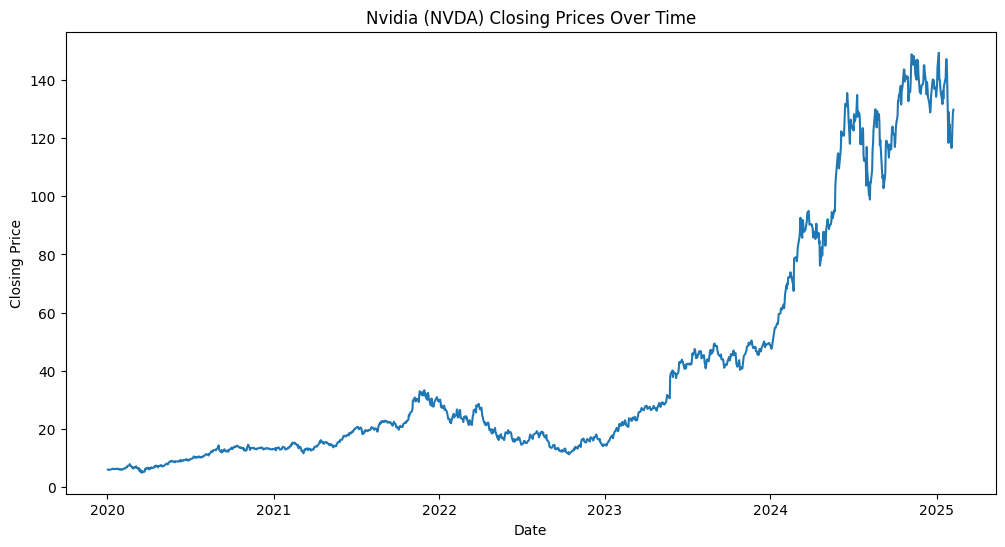

In [40]:
plt.figure(figsize=(12,6))
plt.plot(stock_data["Close"])
plt.title("Nvidia (NVDA) Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [41]:
log_returns = np.log(stock_data['Close']).diff()
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

train_data = train_data.dropna()
test_data = test_data.dropna()

In [ ]:
# calculate volatility
def calculate_volatility(returns, window=21):
    # calculate rolling volatility of returns
    return returns.rolling(window=window).std() * np.sqrt(252) 

log_returns = np.log(stock_data['Close']).diff()
train_size = int(len(log_returns) * 0.8)
train_data = log_returns[:train_size]
test_data = log_returns[train_size:]

train_data = train_data.dropna()
test_data = test_data.dropna()

historical_volatility = calculate_volatility(log_returns)

# ARIMA model
model = ARIMA(train_data, order=(2, 1, 2))
model_fit = model.fit()

In [43]:
# generate forecasts
n_periods = 180
forecasted_returns = model_fit.forecast(steps=n_periods)

# calculate historical volatility with more conservative scaling
historical_vol = log_returns.rolling(window=21).std() * np.sqrt(12) 
current_vol = historical_vol.iloc[-1]

# returns back to prices
last_price = float(stock_data['Close'].iloc[-1])
forecasted_prices = []
upper_bound = []
lower_bound = []
current_price = last_price

forecasted_returns = np.array(forecasted_returns)

for i in range(n_periods):
    # calculate price
    current_price = current_price * np.exp(forecasted_returns[i])
    forecasted_prices.append(current_price)
    
    time_factor = np.sqrt((i + 1)/(12 * 21)) 
    std_dev = current_vol * time_factor
    
    upper = current_price * np.exp(1.28 * std_dev)
    lower = current_price * np.exp(-1.28 * std_dev)
    lower = np.maximum(lower, current_price * 0.5) 
    
    upper_bound.append(float(upper)) 
    lower_bound.append(float(lower)) 

# forecast dataframe with proper dates
forecast_dates = pd.date_range(start=stock_data.index[-1], periods=n_periods, freq='D')
forecast_dataframe = pd.DataFrame({'Date': forecast_dates, 'Forecasted': forecasted_prices, 'Upper_Bound': upper_bound, 'Lower_Bound': lower_bound})

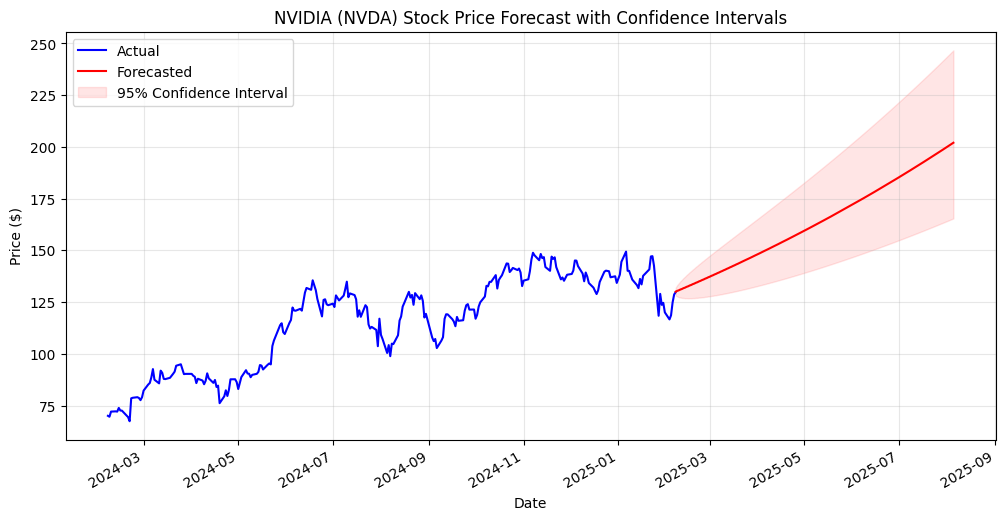


Forecast Summary:
Current Price: $129.84
Forecasted Price (180 days): $202.02
Upper Bound (95% CI): $246.68
Lower Bound (95% CI): $165.45

Historical Volatility (Last 21 days): 18.46%


In [44]:
# plot with confidence intervals
plt.figure(figsize=(12, 6))
# plot actual data
plt.plot(stock_data.index[-252:], stock_data['Close'][-252:], label='Actual', color='b')
# plot forecast
plt.plot(forecast_dataframe['Date'], forecast_dataframe['Forecasted'], label='Forecasted', color='r')
# plot confidence intervals
plt.fill_between(forecast_dataframe['Date'],
                 forecast_dataframe['Lower_Bound'].astype(float),
                 forecast_dataframe['Upper_Bound'].astype(float),
                 color='r', alpha=0.1, label='95% Confidence Interval')
plt.title('NVIDIA (NVDA) Stock Price Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.gcf().autofmt_xdate() 

plt.show()

# statistics
print("\nForecast Summary:")
print(f"Current Price: ${float(last_price):.2f}")
print(f"Forecasted Price (180 days): ${float(forecasted_prices[-1]):.2f}")
print(f"Upper Bound (95% CI): ${float(forecast_dataframe['Upper_Bound'].iloc[-1]):.2f}")
print(f"Lower Bound (95% CI): ${float(forecast_dataframe['Lower_Bound'].iloc[-1]):.2f}")
print(f"\nHistorical Volatility (Last 21 days): {float(historical_vol.iloc[-1]*100):.2f}%")